This page was created from a Jupyter notebook. The original notebook can be found [here](https://github.com/klane/databall/blob/master/notebooks/data-exploration.ipynb). It explores some of the data contained in or derived from the database. First we must import the necessary installed modules.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

Next we need to import a few local modules to calculate some advanced stats not stored in the database and format plots.

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from databall.database import Database
from databall.plotting import format_538
from databall.util import print_df

The command below applies a plot style that is influenced by the beautiful graphs found on [FiveThirtyEight](http://fivethirtyeight.com/). I also wrote a function to further customize my plots to more closely mimick FiveThirtyEight graphs using this [DataQuest article](https://www.dataquest.io/blog/making-538-plots/) as a guide.

In [3]:
plt.style.use('fivethirtyeight')

We then need to connect to the database generated during the [data wrangling](data-wrangling.md) process.

In [4]:
conn = sqlite3.connect('../data/nba.db')

The SQL query below calculates the home team's winning percentage straight up and against the spread since the 1990-91 season and groups the results by season. Specifically, it sums up all occurrences of 'W' in the HOME_WL and HOME_SPREAD_WL columns and divides by the total number of games in a given season. It also calculates the percentage of games that hit the over and a few other average stats that I plot later.

In [5]:
data = pd.read_sql('''
    SELECT
        SEASON,
        100.0 * SUM(CASE WHEN HOME_WL = 'W' THEN 1 ELSE 0 END) / COUNT(HOME_WL) AS HomeWinPct,
        100.0 * SUM(CASE WHEN HOME_SPREAD_WL = 'W' THEN 1 ELSE 0 END) / COUNT(HOME_SPREAD_WL) AS HomeWinPctATS,
        100.0 * SUM(CASE WHEN OU_RESULT = 'O' THEN 1 ELSE 0 END) / COUNT(OU_RESULT) AS OverPct,
        AVG(OVER_UNDER) AS AVG_OVER_UNDER,
        AVG(HOME_SPREAD) AS AVG_HOME_SPREAD,
        2 * AVG(PTS) as AVG_PTS,
        AVG(FG3A) as AVG3
    FROM games
    JOIN betting ON games.ID IS betting.GAME_ID
    JOIN team_game_stats ON games.ID IS team_game_stats.GAME_ID
    GROUP BY SEASON''', conn)

I first wanted to look at the rise of three-point shooting in the NBA. As discussed in the [background](background.md), teams have been shooting more and more threes every season for a while because they are worth more in terms of expected value, and the data clearly indicates that. Since the three-point line was extended in 1997, teams have shot more threes the following season virtually every year.

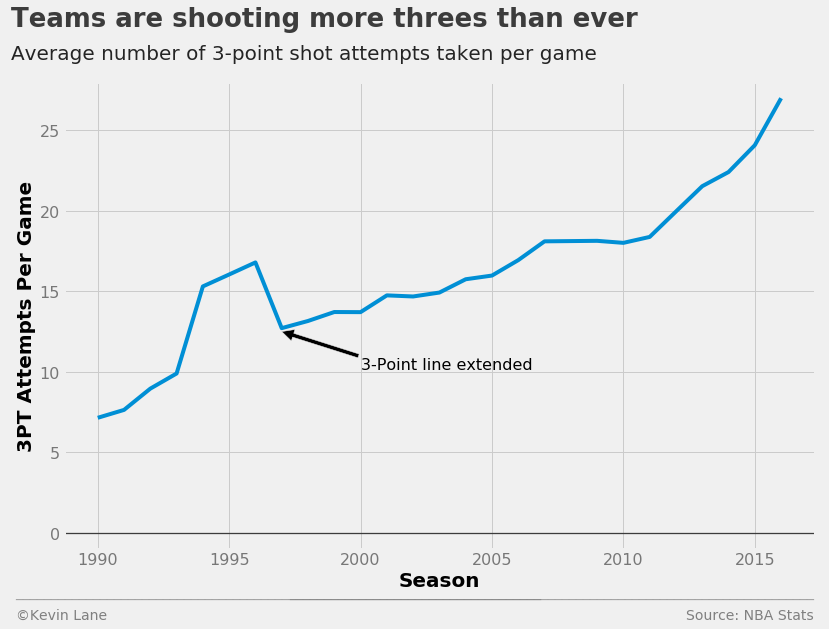

In [6]:
fig = plt.figure(figsize=(12, 8))
plt.plot(data.SEASON, data.AVG3)
plt.annotate('3-Point line extended', xy=(1997, 12.5), xytext=(2000, 10.2), fontsize=16, 
             arrowprops=dict(facecolor='black'))
plt.ylim(-1)
title = 'Teams are shooting more threes than ever'
subtitle = 'Average number of 3-point shot attempts taken per game'
format_538(fig, 'NBA Stats', xlabel='Season', ylabel='3PT Attempts Per Game',
           title=title, subtitle=subtitle, toff=(-0.07, 1.12))
plt.show()

In terms of predicting game winners, a reasonable baseline prediction without knowing what two teams are playing is probably that the home team wins. Let's take a look at how often that actually happens in the NBA. The plot below shows home team win percentage across the league from 1990-2016. The chart along with the annotation show that the home team wins about 60% of the time historically. That rate is also remarkably consistent. It has a standard deviation of less than 2% and has stayed within about $$\pm$$4% since the 1990-91 season. FiveThirtyEight [reported](https://fivethirtyeight.com/features/a-home-playoff-game-is-a-big-advantage-unless-you-play-hockey/) a similar percentage when analyzing home court/field/ice advantages of the four major American sports. They calculated that the home team in the NBA has won 59.9% of regular season games since the 2000 season. They also estimated that playing at home provides the biggest advantage in the NBA, where home teams win nearly 10% more games than expected had all games been played at neutral sites. Contrast that with MLB, where home teams win only 4% more games than expected. It is interesting to note that regardless of the sport, FiveThirtyEight's models expect the "home" team to win about 50% of the time on neutral sites, which makes sense when averaged across all teams and multiple seasons.

The plot also shows winning percentage against the spread (ATS) and percentage of games that hit the over. It really shows how skilled oddsmakers are at setting point spreads and over/under lines. Both percentages 

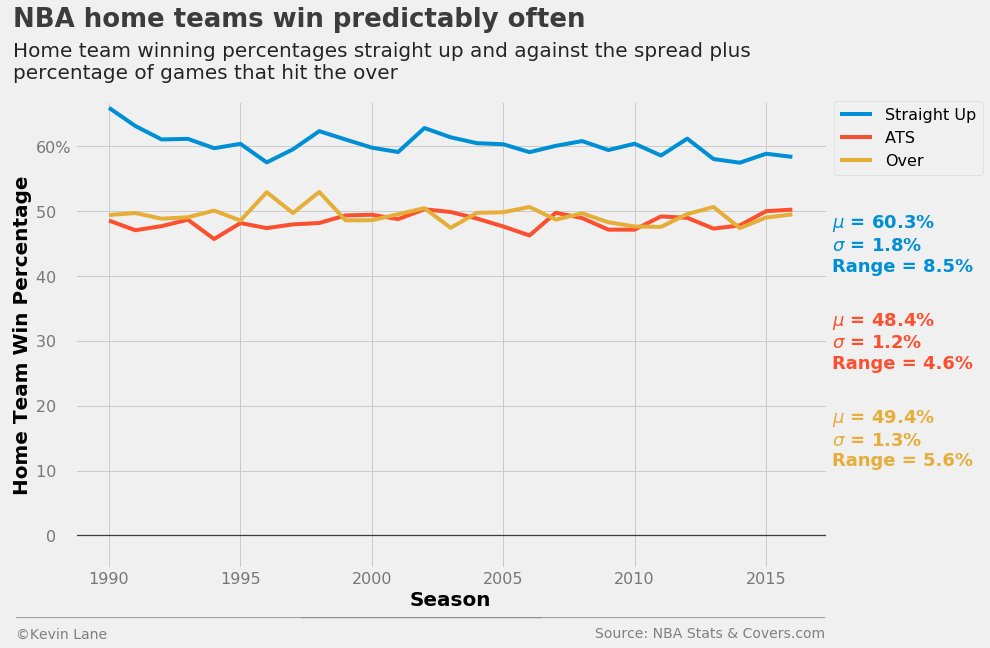

In [7]:
wpct = data.HomeWinPct
wpct_ats = data.HomeWinPctATS
opct = data.OverPct

fig = plt.figure(figsize=(12, 8))
p = []
p += plt.plot(data.SEASON, wpct, label='Straight Up')
p += plt.plot(data.SEASON, wpct_ats, label='ATS')
p += plt.plot(data.SEASON, opct, label='Over')
plt.ylim(-5)

plt.text(2017.5, 41, '$\mu$ = {0:.1f}%\n$\sigma$ = {1:.1f}%\nRange = {2:.1f}%'
         .format(np.mean(wpct), np.std(wpct), np.ptp(wpct)),
         fontsize=18, fontweight='bold', color=p[0].get_color())
plt.text(2017.5, 26, '$\mu$ = {0:.1f}%\n$\sigma$ = {1:.1f}%\nRange = {2:.1f}%'
         .format(np.mean(wpct_ats), np.std(wpct_ats), np.ptp(wpct_ats)),
         fontsize=18, fontweight='bold', color=p[1].get_color())
plt.text(2017.5, 11, '$\mu$ = {0:.1f}%\n$\sigma$ = {1:.1f}%\nRange = {2:.1f}%'
         .format(np.mean(opct), np.std(opct), np.ptp(opct)),
         fontsize=18, fontweight='bold', color=p[2].get_color())

xlabel = 'Season'
ylabel = 'Home Team Win Percentage'
title = 'NBA home teams win predictably often'
subtitle = '''Home team winning percentages straight up and against the spread plus
percentage of games that hit the over'''
plt.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)
format_538(fig, 'NBA Stats & Covers.com', xlabel=xlabel, ylabel=ylabel, title=title, subtitle=subtitle,
           xoff=(-0.09, 1.01), toff=(-0.082, 1.16), soff=(-0.082, 1.05), suffix='%', suffix_offset=3)
plt.show()

## Historically Great Teams

Now let's calculate some advanced stats from the basic box score data. The code below returns a Pandas DataFrame with season-averaged team offensive and defensive ratings (points scored/allowed per 100 possessions), as well as SRS defined during [data wrangling](data-wrangling.md).

In [8]:
database = Database('../data/nba.db')
season_stats = database.season_stats()

We are first going to look at teams that have some of the best offenses and defenses in NBA history. Since the team stats table includes a team ID that maps to a teams table, we need to pull in the teams table to better identify which teams we are looking at.

In [9]:
teams = pd.read_sql('SELECT * FROM TEAMS', conn)

Below are the limits for what defines a great offense, defense, and well-balanced team (high net rating). These limits are not formally defined and are merely selected such that the resulting number of teams is small.

In [10]:
off_lim = 114
def_lim = 98
net_lim = 9
off_flag = (season_stats.TEAM_OFF_RTG > off_lim) & (season_stats.SEASON >= 1990)
def_flag = (season_stats.TEAM_DEF_RTG < def_lim) & (season_stats.SEASON >= 1990)
net_flag = (season_stats.TEAM_NET_RTG > net_lim) & (season_stats.SEASON >= 1990)
stats = ['SEASON', 'TEAM_ID', 'TEAM_OFF_RTG', 'TEAM_DEF_RTG', 'TEAM_NET_RTG', 'TEAM_SRS']

There are 15 teams since the 1990-91 season with an offensive rating greater than 114 and 4 of them are Jordan-led Bulls teams. The only other teams to appear more than once are the Suns (one led by Charles Barkley and two by the duo of Steve Nash and Amar'e Stoudemire) and the Warriors (one led by hall of famer Chris Mullin and the record-setting 2015-16 team). Note that the NBA's database does not differentiate teams that change location and/or mascots, so the table identifies the 1994 Oklahoma City Thunder, even though they were the Seattle SuperSonics at the time.

In [11]:
# Isolate desired teams
best_off = season_stats.loc[off_flag, stats]

# Merge with teams table to add team information
best_off = teams.merge(best_off, left_on='ID', right_on='TEAM_ID')

# Remove ID columns
best_off = best_off[[c for c in best_off.columns if 'ID' not in c]]

# Sort by descending offensive rating
print_df(best_off.sort_values(by='TEAM_OFF_RTG', ascending=False))

ABBREVIATION,CITY,MASCOT,SEASON,TEAM_OFF_RTG,TEAM_DEF_RTG,TEAM_NET_RTG,TEAM_SRS
CHI,Chicago,Bulls,1991,116.189211,105.151816,11.037395,10.068209
CHI,Chicago,Bulls,1995,115.933867,102.438493,13.495374,11.799077
ORL,Orlando,Magic,1994,115.824746,108.447942,7.376804,6.438905
GSW,Golden State,Warriors,2016,115.569072,103.967168,11.601904,11.351390
OKC,Oklahoma City,Thunder,1994,115.429696,106.876043,8.553653,7.907164
PHX,Phoenix,Suns,2009,115.341356,110.211671,5.129685,4.677408
CHI,Chicago,Bulls,1990,115.229301,105.703474,9.525826,8.565998
UTA,Utah,Jazz,1994,114.985616,106.354448,8.631169,7.751535
PHX,Phoenix,Suns,1994,114.930813,110.902597,4.028215,3.849692
HOU,Houston,Rockets,2016,114.745295,109.006817,5.738478,5.844508


There are 11 teams since 1990 with a defensive rating under 98 and 3 of them are late 90s/early 2000s Spurs teams with Tim Duncan, two of which featured hall of famer David Robinson. What is more impressive is that they are the only team to grace this list more than once.

In [12]:
# Isolate desired teams
best_def = season_stats.loc[def_flag, stats]

# Merge with teams table to add team information
best_def = teams.merge(best_def, left_on='ID', right_on='TEAM_ID')

# Remove ID columns
best_def = best_def[[c for c in best_def.columns if 'ID' not in c]]

# Sort by ascending defensive rating
print_df(best_def.sort_values(by='TEAM_DEF_RTG'))

ABBREVIATION,CITY,MASCOT,SEASON,TEAM_OFF_RTG,TEAM_DEF_RTG,TEAM_NET_RTG,TEAM_SRS
SAS,San Antonio,Spurs,2003,102.248071,94.178366,8.069705,7.512427
SAS,San Antonio,Spurs,1998,104.036733,95.000784,9.035949,7.151218
DET,Detroit,Pistons,2003,102.057437,95.440557,6.616880,5.035363
ATL,Atlanta,Hawks,1998,100.516244,97.138526,3.377719,2.790164
IND,Indiana,Pacers,2003,103.866828,97.324036,6.542792,4.932295
ORL,Orlando,Magic,1998,100.297189,97.382225,2.914964,3.082168
NYK,New York,Knicks,1998,98.636273,97.471817,1.164456,1.423433
PHI,Philadelphia,76ers,1998,99.928127,97.632210,2.295917,2.528796
POR,Portland,Trail Blazers,1998,104.759421,97.734222,7.025199,5.697009
SAS,San Antonio,Spurs,2000,106.556068,97.962401,8.593667,7.916999


The 17 teams listed below have a net rating greater than 9 and are some of the strongest teams in NBA history. These include 4 of the Jordan-led Bulls and two of the recent Warriors teams. Only one of the strong defensive teams isolated above make the cut, while 5 of the strong offensive teams appear. As before, note that the 1993 Oklahoma City Thunder were in fact the Seattle SuperSonics.

In [13]:
# Isolate desired teams
best_net = season_stats.loc[net_flag, stats]

# Merge with teams table to add team information
best_net = teams.merge(best_net, left_on='ID', right_on='TEAM_ID')

# Remove ID columns
best_net = best_net[[c for c in best_net.columns if 'ID' not in c]]

# Sort by descending net rating
print_df(best_net.sort_values(by='TEAM_NET_RTG', ascending=False))

ABBREVIATION,CITY,MASCOT,SEASON,TEAM_OFF_RTG,TEAM_DEF_RTG,TEAM_NET_RTG,TEAM_SRS
CHI,Chicago,Bulls,1995,115.933867,102.438493,13.495374,11.799077
CHI,Chicago,Bulls,1996,114.352283,102.373550,11.978733,10.697142
GSW,Golden State,Warriors,2016,115.569072,103.967168,11.601904,11.351390
SAS,San Antonio,Spurs,2015,110.290021,98.962236,11.327785,10.276618
BOS,Boston,Celtics,2007,110.171323,98.933715,11.237609,9.307345
CHI,Chicago,Bulls,1991,116.189211,105.151816,11.037395,10.068209
GSW,Golden State,Warriors,2015,114.495585,103.776436,10.719149,10.380270
GSW,Golden State,Warriors,2014,111.603607,101.354296,10.249311,10.008125
CLE,Cleveland,Cavaliers,2008,112.441598,102.432204,10.009394,8.680389
OKC,Oklahoma City,Thunder,2012,112.398592,102.609581,9.789011,9.149670


The following table shows all NBA champions since the 1990-91 season. Not surprisingly, most of the champions have solid net ratings and SRS numbers with the 1995 Bulls shining above all other teams. The weakest champion by these measures is the 1994 Rockets led by hall of famers Hakeem Olajuwon and Clyde Drexler.

In [14]:
# Create champions table that identifies which team won the NBA championship each season
champs = pd.DataFrame({'SEASON': range(1990, 2017),
                       'ABBREVIATION': ['CHI', 'CHI', 'CHI', 'HOU', 'HOU', 'CHI', 'CHI', 'CHI', 'SAS',
                                        'LAL', 'LAL', 'LAL', 'SAS', 'DET', 'SAS', 'MIA', 'SAS', 'BOS',
                                        'LAL', 'LAL', 'DAL', 'MIA', 'MIA', 'SAS', 'GSW', 'CLE', 'GSW']})
# Isolate desired stats from all teams
champ_stats = season_stats[stats]

# Merge with teams table to add team information
champ_stats = teams.merge(champ_stats, left_on='ID', right_on='TEAM_ID')

# Merge with champs table created above
columns = ['ABBREVIATION', 'SEASON']
champ_stats = champs.merge(champ_stats, left_on=columns, right_on=columns)

# Remove ID columns
champ_stats = champ_stats[[c for c in best_net.columns if 'ID' not in c]]
print_df(champ_stats)

ABBREVIATION,CITY,MASCOT,SEASON,TEAM_OFF_RTG,TEAM_DEF_RTG,TEAM_NET_RTG,TEAM_SRS
CHI,Chicago,Bulls,1990,115.229301,105.703474,9.525826,8.565998
CHI,Chicago,Bulls,1991,116.189211,105.151816,11.037395,10.068209
CHI,Chicago,Bulls,1992,113.620324,106.822864,6.797459,6.192637
HOU,Houston,Rockets,1993,106.444671,101.900362,4.544309,4.194021
HOU,Houston,Rockets,1994,110.403045,108.140634,2.262411,2.318131
CHI,Chicago,Bulls,1995,115.933867,102.438493,13.495374,11.799077
CHI,Chicago,Bulls,1996,114.352283,102.373550,11.978733,10.697142
CHI,Chicago,Bulls,1997,107.696343,99.779691,7.916652,7.244613
SAS,San Antonio,Spurs,1998,104.036733,95.000784,9.035949,7.151218
LAL,Los Angeles,Lakers,1999,107.325502,98.224840,9.100663,8.413792


The scatter plot below shows all teams since 1990 represented by their offensive and defensive ratings. The strongest teams are towards the bottom right, those that score a lot and do not give up many points. The line represents a constant net rating of 9, below which are the 16 teams listed above that have a net rating greater than 9.

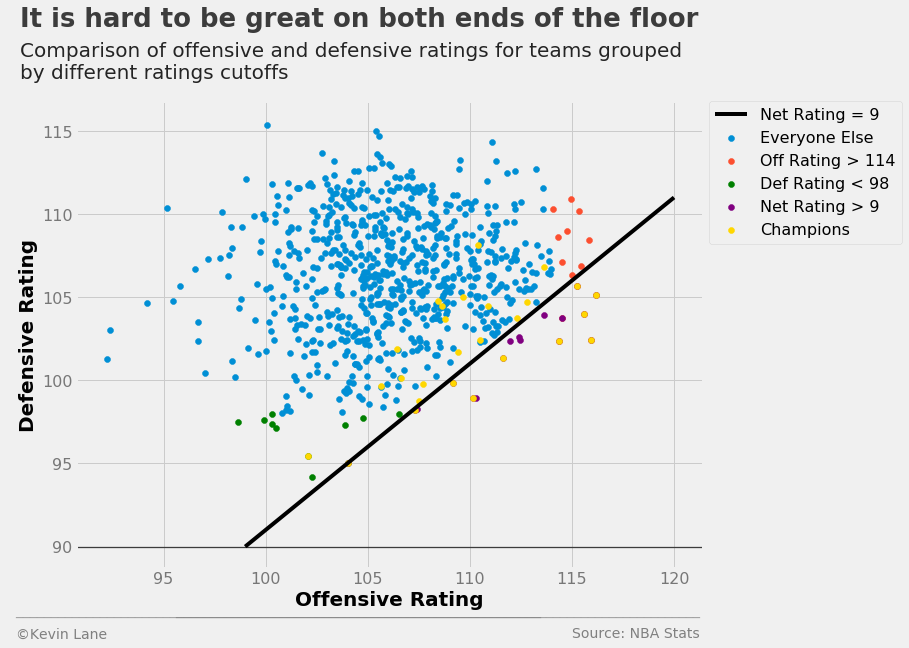

In [15]:
# Add line of constant net rating
x = np.array([99, 120])
fig = plt.figure(figsize=(10, 8))
plt.plot(x, x-net_lim, 'black', label='Net Rating = {:d}'.format(net_lim))

# Isolate teams that do not make the offensive/defensive/net rating cutoffs
others = season_stats.loc[~off_flag & ~def_flag & ~net_flag & (season_stats.SEASON >= 1990), stats]
others = teams.merge(others, left_on='ID', right_on='TEAM_ID')

# Remove the champions with an outer join
columns = ['ABBREVIATION', 'SEASON']
others = champs.merge(others, left_on=columns, right_on=columns, how='outer', indicator=True)
others = others[others._merge == 'right_only']

# Plot data
plt.scatter(x='TEAM_OFF_RTG', y='TEAM_DEF_RTG', data=others, label='Everyone Else')
plt.scatter(x='TEAM_OFF_RTG', y='TEAM_DEF_RTG', data=best_off, label='Off Rating > {:d}'.format(off_lim))
plt.scatter(x='TEAM_OFF_RTG', y='TEAM_DEF_RTG', data=best_def, label='Def Rating < {:d}'.format(def_lim),
            color='green')
plt.scatter(x='TEAM_OFF_RTG', y='TEAM_DEF_RTG', data=best_net, label='Net Rating > {:d}'.format(net_lim),
            color='purple')
plt.scatter(x='TEAM_OFF_RTG', y='TEAM_DEF_RTG', data=champ_stats, label='Champions', color='gold')

# Add legend for format plot
plt.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)
title = 'It is hard to be great on both ends of the floor'
subtitle = '''Comparison of offensive and defensive ratings for teams grouped
by different ratings cutoffs'''
format_538(fig, 'NBA Stats', xlabel='Offensive Rating', ylabel='Defensive Rating', title=title,
           subtitle=subtitle, xoff=(-0.11, 1.01), toff=(-0.09, 1.16), soff=(-0.09, 1.05), bottomtick=90)
plt.show()

## Team Strength Distribution

The histogram and KDE of team SRS below show that teams are fairly normally distributed. The best fit normal distribution has a mean of essentially zero with a standard deviation of about 4.6 points. A zero-mean distribution makes sense here because an SRS of zero indicates a perfectly average team.

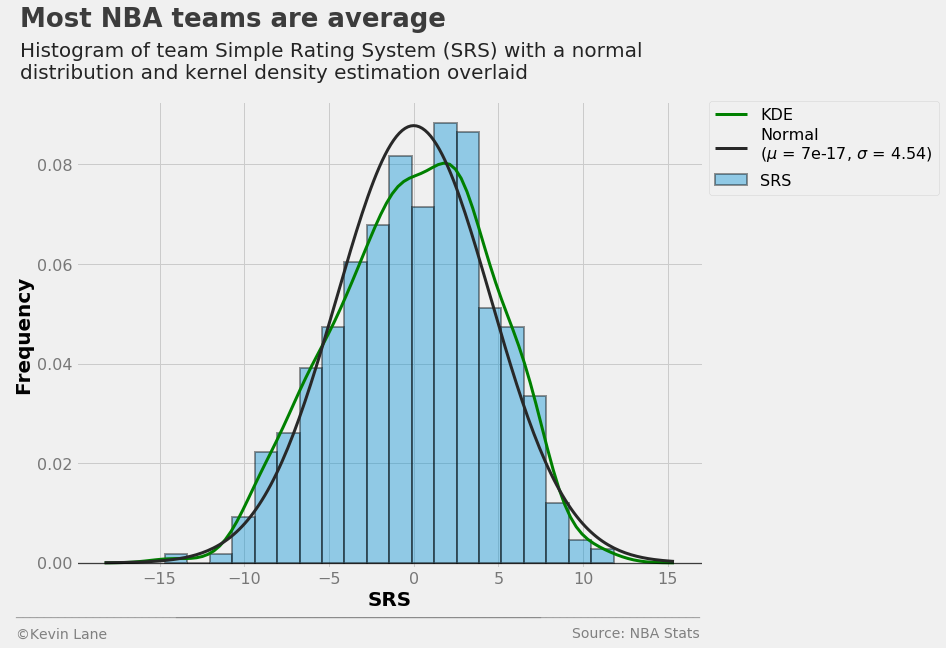

In [16]:
srs = season_stats['TEAM_SRS']
(mu, sigma) = norm.fit(srs)

fig = plt.figure(figsize=(10, 8))
sns.distplot(srs, fit=norm, kde=True, kde_kws={'label': 'KDE', 'color': 'green', 'linewidth': 3},
             hist_kws={'label': 'SRS', 'edgecolor': 'k', 'linewidth': 2},
             fit_kws={'label': 'Normal\n($\mu$ = {0:.2g}, $\sigma$ = {1:.2f})'
                      .format(mu, sigma), 'linewidth': 3})
plt.ylim(-0.001)
plt.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)
title = 'Most NBA teams are average'
subtitle = '''Histogram of team Simple Rating System (SRS) with a normal
distribution and kernel density estimation overlaid'''
format_538(fig, 'NBA Stats', xlabel='SRS', ylabel='Frequency', title=title,
           subtitle=subtitle, xoff=(-0.11, 1.01), toff=(-0.09, 1.16), soff=(-0.09, 1.05))
plt.show()

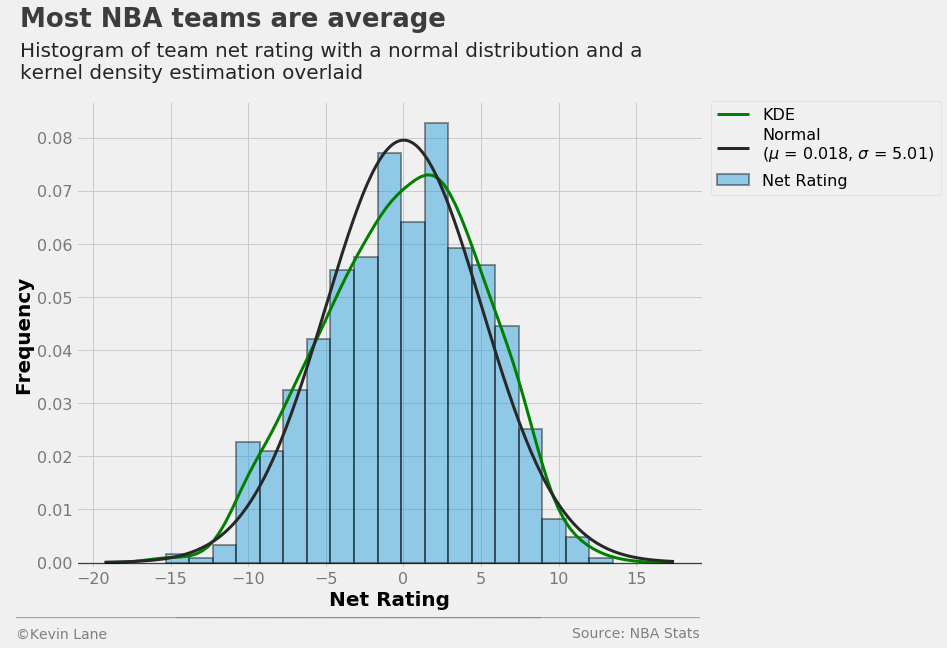

In [17]:
net_rtg = season_stats['TEAM_NET_RTG']
(mu, sigma) = norm.fit(net_rtg)

fig = plt.figure(figsize=(10, 8))
sns.distplot(net_rtg, fit=norm, kde=True, kde_kws={'label': 'KDE', 'color': 'green', 'linewidth': 3},
             hist_kws={'label': 'Net Rating', 'edgecolor': 'k', 'linewidth': 2},
             fit_kws={'label': 'Normal\n($\mu$ = {0:.2g}, $\sigma$ = {1:.2f})'
                      .format(mu, sigma), 'linewidth': 3})

plt.ylim(-0.001)
plt.legend(fontsize=16, bbox_to_anchor=(1.38, 1), borderaxespad=0)
title = 'Most NBA teams are average'
subtitle = '''Histogram of team net rating with a normal distribution and a
kernel density estimation overlaid'''
format_538(fig, 'NBA Stats', xlabel='Net Rating', ylabel='Frequency', title=title,
           subtitle=subtitle, xoff=(-0.11, 1.01), toff=(-0.09, 1.16), soff=(-0.09, 1.05))
plt.show()

## Home vs. Away Strength

The next step is to look at games in terms of home and away team stats. The code below joins the games table with the stats table initially by home team stats and followed by away team stats.

In [18]:
seasons = season_stats.filter(regex='SEASON|TEAM')
games = pd.read_sql('SELECT * FROM games JOIN betting ON games.ID is betting.GAME_ID', conn)
games = games.merge(seasons, left_on=['SEASON', 'HOME_TEAM_ID'], right_on=['SEASON', 'TEAM_ID'])
games = games.merge(seasons, left_on=['SEASON', 'AWAY_TEAM_ID'], right_on=['SEASON', 'TEAM_ID'], 
                    suffixes=('', '_AWAY'))

The plot below shows a 2D KDE that compares home and away team SRS. By inspection, the majority of games occur between teams with SRS values within 5 points of average. This makes intuitive sense given the standard deviation of 4.6 points calculated above. Assuming the Gaussian distribution above, more than 68% of all teams since 1990 have SRS values with a magnitude less than 5 based on the definition of a normal distribution. The distribution appears symmetric about a y=x line because under normal circumstances (each team plays a full season), teams have the same number of home and away games. 

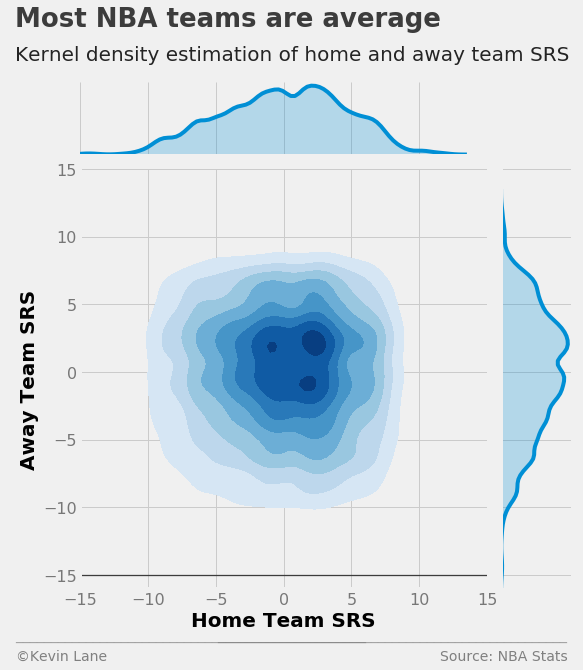

In [19]:
ax = sns.jointplot(x='TEAM_SRS', y='TEAM_SRS_AWAY', data=games, kind='kde', cmap='Blues',
                   shade_lowest=False, stat_func=None, xlim=(-15, 15), ylim=(-15, 15), size=8)
ax.set_axis_labels(xlabel='Home Team SRS', ylabel='Away Team SRS')

plt.ylim(-16)
title = 'Most NBA teams are average'
subtitle = '''Kernel density estimation of home and away team SRS'''
format_538(plt.gcf(), 'NBA Stats', ax=ax.ax_joint, title=title, subtitle=subtitle, xoff=(-0.18, 1.22),
           yoff=(-0.12, -0.17), toff=(-0.16, 1.34), soff=(-0.16, 1.26), bottomtick=-15, n=50)
plt.show()

The function below makes and customizes KDE plots of home and away team stats.

In [20]:
def kde(data, stat, label, title, ax):
    stat = 'TEAM_' + stat
    sns.kdeplot(data[stat], data[stat + '_AWAY'], cmap='Blues', shade=True, shade_lowest=False, ax=ax)
    ax.plot(0, 0, 'or', markersize=10)
    ax.set_xlabel('Home Team ' + label)
    ax.set_ylabel('Away Team ' + label)
    ax.set_title(title)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)

A better view of this data is to separate games into home team wins and losses. The plots below show KDE plots of SRS for home team wins and losses with a red marker added to easily identify the origin (average home and away teams). The high-density area towards the lower right of the origin for home team wins (left plot) indicates there are many games in the dataset where above-average home teams beat below-average away teams, which is not a surprising revelation. We draw the opposite conclusion for home team losses. The highest density occurs towards the upper left of the origin, meaning games where a below-average home team plays an above-average visiting teams typically does not go well for the home team. There is also a small cluster of games in the left plot where above-average home teams beat above-average visitors of roughly equal quality. This may be caused by home court advantage, but was not investigated further.

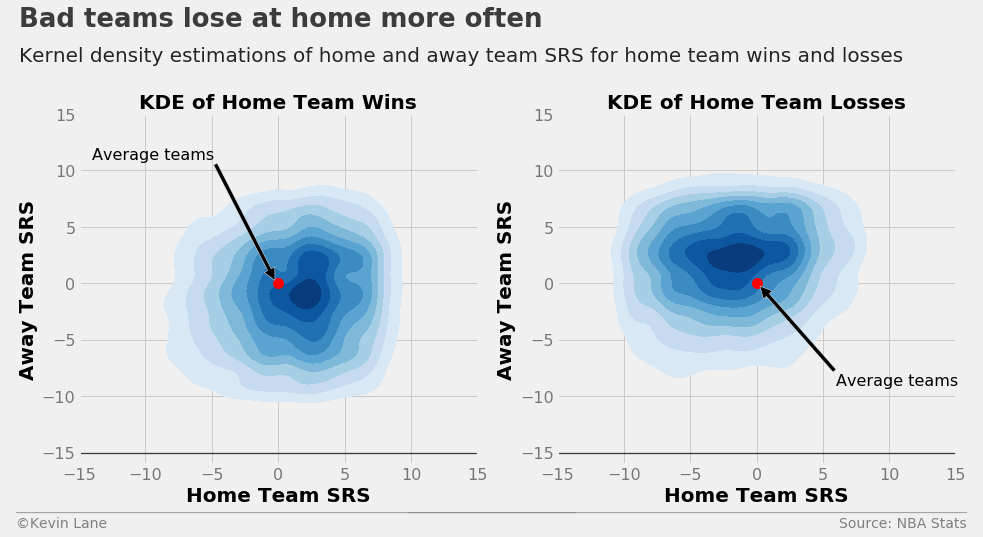

In [21]:
fig = plt.figure(figsize=(14, 6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

# Find games where the home team won
kde(games[games.HOME_WL=='W'], 'SRS', 'SRS', 'KDE of Home Team Wins', ax1)
ax1.annotate('Average teams', xy=(-0.25, 0.25), xytext=(-14, 11), fontsize=16, 
             arrowprops=dict(facecolor='black'))
ax1.set_ylim(-16)

# Find games where the home team lost
kde(games[games.HOME_WL=='L'], 'SRS', 'SRS', 'KDE of Home Team Losses', ax2)
ax2.annotate('Average teams', xy=(0.25, -0.25), xytext=(6, -9), fontsize=16, 
             arrowprops=dict(facecolor='black'))
ax2.set_ylim(-16)

title = 'Bad teams lose at home more often'
subtitle = 'Kernel density estimations of home and away team SRS for home team wins and losses'
format_538(fig, 'NBA Stats', ax=(ax1, ax2), title=title, subtitle=subtitle, xoff=(-0.18, 2.25),
           yoff=(-0.13, -0.18), toff=(-.15, 1.25), soff=(-0.15, 1.15), bottomtick=[-15, -15], n=80)
plt.show()

The KDE plots below repeat those above for team net ratings (offensive rating - defensive rating). They illustrate that the same trends hold true for net ratings as did for SRS above.

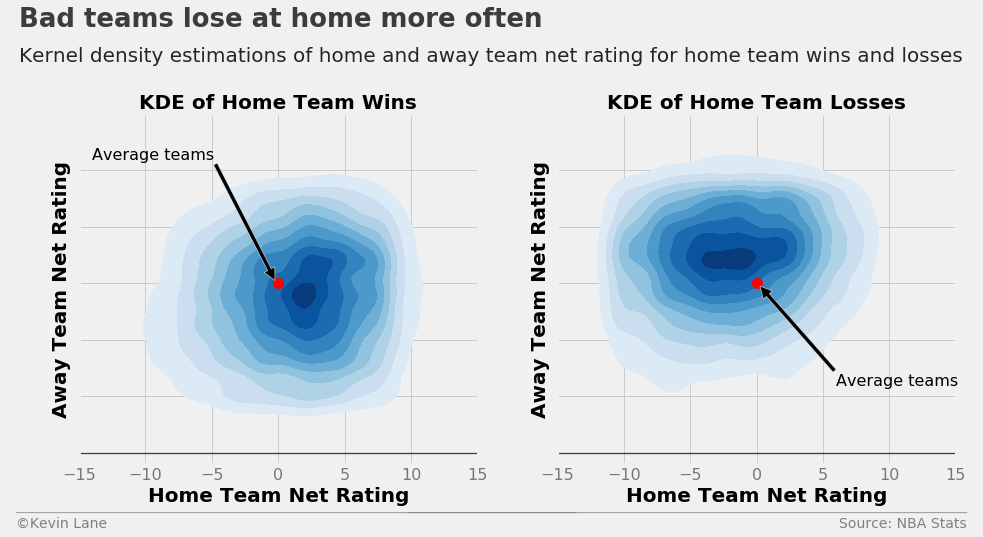

In [22]:
plt.figure(figsize=(14, 6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

# Find games where the home team won
kde(games[games.HOME_WL=='W'], 'NET_RTG', 'Net Rating', 'KDE of Home Team Wins', ax1)
ax1.annotate('Average teams', xy=(-0.25, 0.25), xytext=(-14, 11), fontsize=16, 
             arrowprops=dict(facecolor='black'))
ax1.set_ylim(-16)

# Find games where the home team lost
kde(games[games.HOME_WL=='L'], 'NET_RTG', 'Net Rating', 'KDE of Home Team Losses', ax2)
ax2.annotate('Average teams', xy=(0.25, -0.25), xytext=(6, -9), fontsize=16, 
             arrowprops=dict(facecolor='black'))
ax2.set_ylim(-16)

title = 'Bad teams lose at home more often'
subtitle = 'Kernel density estimations of home and away team net rating for home team wins and losses'
format_538(fig, 'NBA Stats', ax=(ax1, ax2), title=title, subtitle=subtitle, xoff=(-0.18, 2.25),
           yoff=(-0.13, -0.18), toff=(-.15, 1.25), soff=(-0.15, 1.15), bottomtick=[-15, -15], n=80)
plt.show()

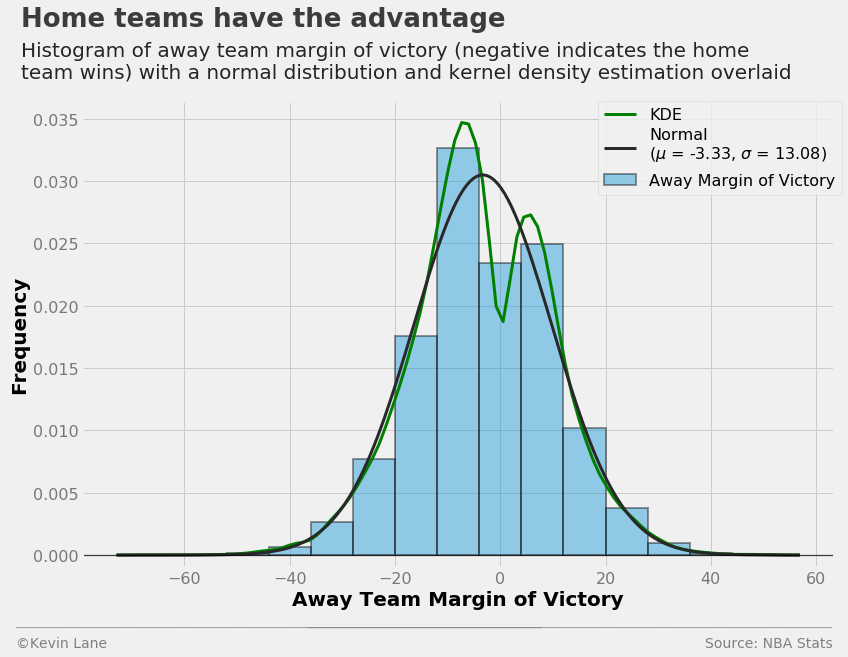

In [23]:
mov = pd.read_sql('''
    SELECT SEASON, PLUS_MINUS
    FROM team_game_stats
    JOIN games
    ON team_game_stats.GAME_ID IS games.ID
    AND team_game_stats.TEAM_ID = games.AWAY_TEAM_ID''', conn)


mov = mov.PLUS_MINUS
(mu, sigma) = norm.fit(mov)

fig = plt.figure(figsize=(12, 8))
ax = sns.distplot(mov, bins=15, fit=norm, kde=True,
                  kde_kws={'label': 'KDE', 'color': 'green', 'linewidth': 3},
                  hist_kws={'label': 'Away Margin of Victory', 'edgecolor': 'k', 'linewidth': 2},
                  fit_kws={'label': 'Normal\n($\mu$ = {0:.2f}, $\sigma$ = {1:.2f})'.format(mu, sigma),
                           'linewidth': 3})

plt.ylim(-0.001)
plt.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)
title = 'Home teams have the advantage'
subtitle = '''Histogram of away team margin of victory (negative indicates the home
team wins) with a normal distribution and kernel density estimation overlaid'''
format_538(fig, 'NBA Stats', xlabel='Away Team Margin of Victory', ylabel='Frequency', title=title,
           subtitle=subtitle, xoff=(-0.1, 1.01), toff=(-0.082, 1.16), soff=(-0.082, 1.05), yoff=(-0.12, -0.17))
plt.show()

# Point Spreads

In [24]:
bets = pd.read_sql('SELECT * FROM games JOIN betting ON games.ID is betting.GAME_ID', conn)
bets = bets.drop(['ID', 'GAME_ID', 'HOME_TEAM_ID', 'AWAY_TEAM_ID'], 1)
print_df(bets.head())

SEASON,GAME_DATE,MATCHUP,HOME_WL,OVER_UNDER,OU_RESULT,HOME_SPREAD,HOME_SPREAD_WL
1990,1990-11-10,PHX vs. DEN,W,293.5,O,-19.5,W
1990,1990-12-29,WAS vs. DEN,W,244.0,O,-10.5,W
1990,1990-11-07,SAN vs. DEN,W,274.0,O,-17.0,L
1990,1990-11-02,DEN vs. GOS,L,310.0,O,2.0,L
1990,1990-12-30,ORL vs. DEN,W,250.5,O,-11.0,W


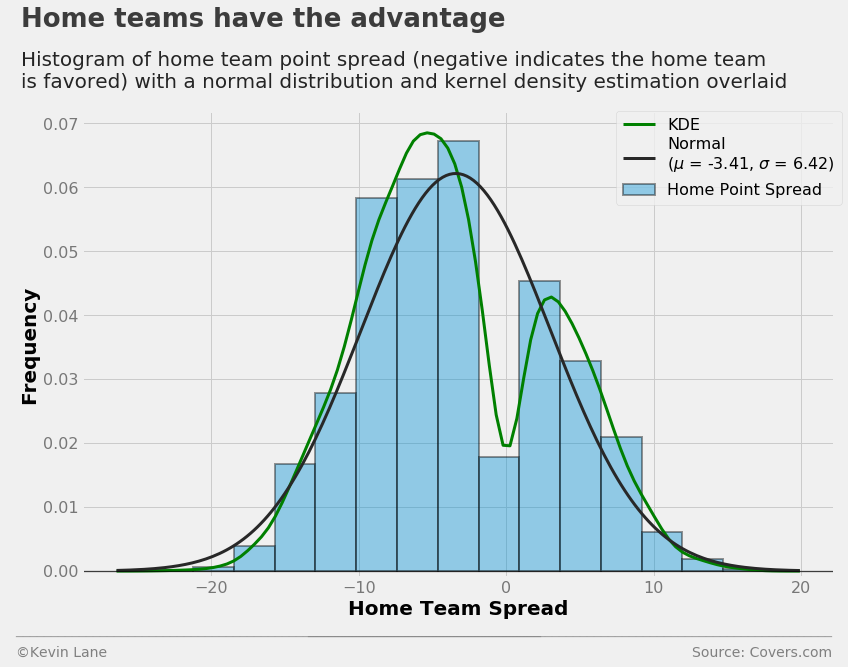

In [25]:
bets = pd.read_sql('SELECT * FROM betting', conn)
spread = bets.HOME_SPREAD.dropna()
(mu, sigma) = norm.fit(spread)

fig = plt.figure(figsize=(12, 8))
ax = sns.distplot(spread, bins=15, fit=norm, kde=True,
                  kde_kws={'label': 'KDE', 'color': 'green', 'linewidth': 3},
                  hist_kws={'label': 'Home Point Spread', 'edgecolor': 'k', 'linewidth': 2},
                  fit_kws={'label': 'Normal\n($\mu$ = {0:.2f}, $\sigma$ = {1:.2f})'.format(mu, sigma),
                           'linewidth': 3})

plt.ylim(-0.001)
plt.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)
title = 'Home teams have the advantage'
subtitle = '''Histogram of home team point spread (negative indicates the home team
is favored) with a normal distribution and kernel density estimation overlaid'''
format_538(fig, 'Covers.com', xlabel='Home Team Spread', ylabel='Frequency', title=title, subtitle=subtitle,
           xoff=(-0.1, 1.01), toff=(-0.082, 1.18), soff=(-0.082, 1.05), yoff=(-0.12, -0.17))
plt.show()

In [26]:
data_mov = pd.read_sql('''
    SELECT
        SEASON,
        AVG(PLUS_MINUS) as AVG_PLUS_MINUS
    FROM team_game_stats
    JOIN games
    ON team_game_stats.GAME_ID IS games.ID
    AND team_game_stats.TEAM_ID = games.AWAY_TEAM_ID
    WHERE SEASON >= 1990
    GROUP BY SEASON''', conn)

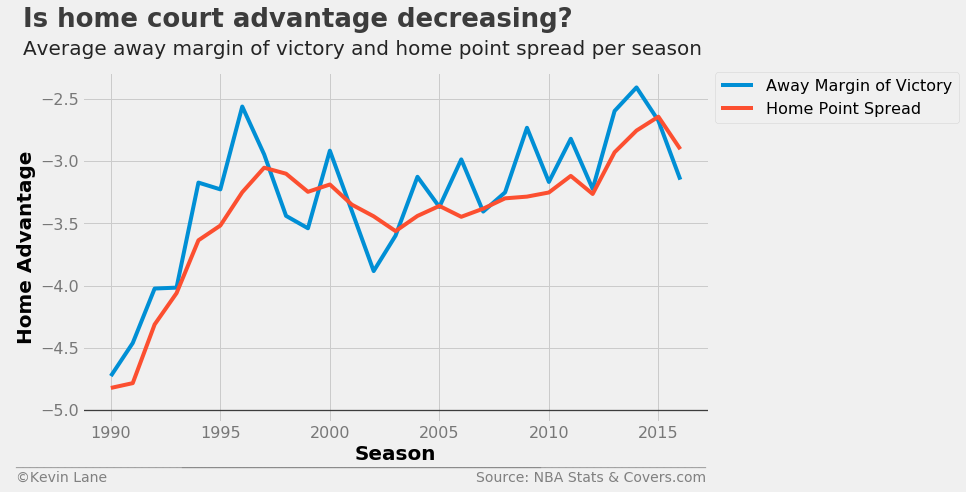

In [27]:
fig = plt.figure(figsize=(10, 6))
plt.plot(data_mov.SEASON, data_mov.AVG_PLUS_MINUS, label='Away Margin of Victory')
plt.plot(data.SEASON, data.AVG_HOME_SPREAD, label='Home Point Spread')
plt.xlabel('Season')
plt.ylabel('Home Advantage')
plt.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.ylim(-5.1)

title = 'Is home court advantage decreasing?'
subtitle = 'Average away margin of victory and home point spread per season'
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, xoff=(-0.12, 1.01),
           yoff=(-0.12, -0.17), toff=(-0.094, 1.13), soff=(-0.094, 1.05), bottomtick=-5)
plt.show()

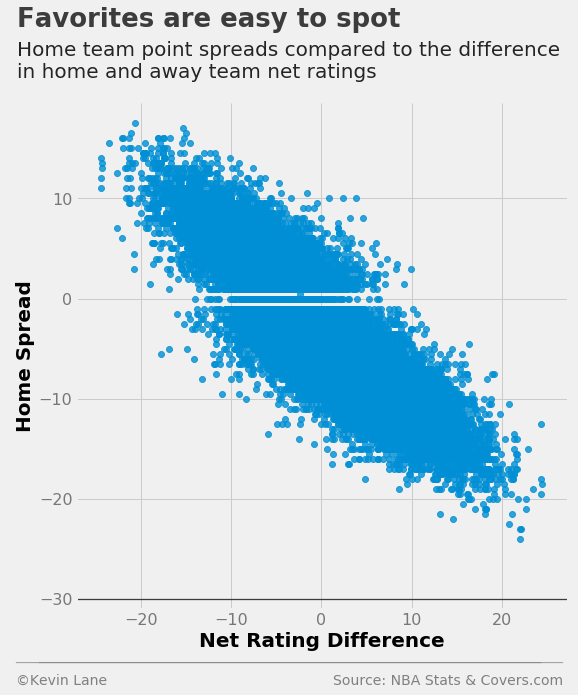

In [28]:
games['NET_RTG'] = games.TEAM_NET_RTG - games.TEAM_NET_RTG_AWAY
games = games.dropna()

# fig = plt.figure(figsize=(12, 8))
ax = sns.lmplot(x='NET_RTG', y='HOME_SPREAD', data=games, fit_reg=False, size=8)
plt.xlabel('Net Rating Difference')
plt.ylabel('Home Spread')
plt.ylim(-31)

title = 'Favorites are easy to spot'
subtitle = '''Home team point spreads compared to the difference
in home and away team net ratings'''
format_538(plt.gcf(), 'NBA Stats & Covers.com', title=title, subtitle=subtitle,
           xoff=(-0.14, 1.01), toff=(-0.12, 1.15), soff=(-0.12, 1.05), bottomtick=-30)

# plt.grid()
plt.show()

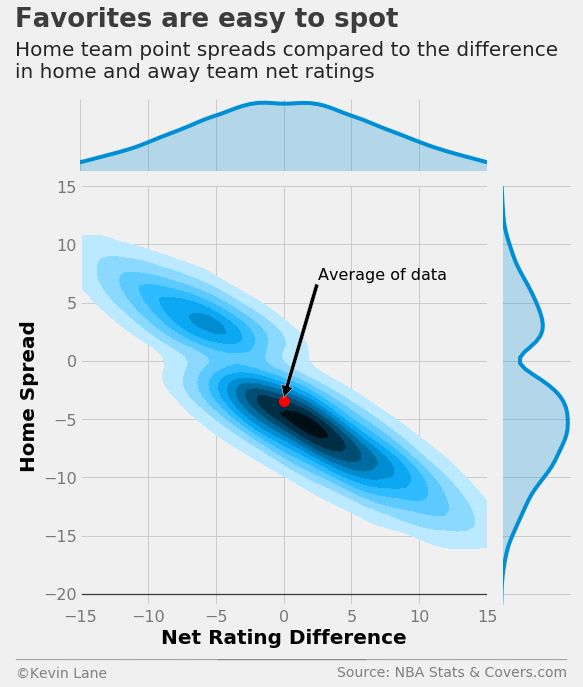

In [29]:
mean_net_rtg = games.NET_RTG.mean()
ax = sns.jointplot(x='NET_RTG', y='HOME_SPREAD', data=games, kind='kde',
                  shade_lowest=False, stat_func=None, xlim=(-15, 15), ylim=(-15, 15), size=8)
ax.set_axis_labels(xlabel='Net Rating Difference', ylabel='Home Spread')
ax.ax_joint.plot(mean_net_rtg, mu, 'or', markersize=10)
ax.ax_joint.annotate('Average of data', xy=(mean_net_rtg, mu+0.25), xytext=(2.5, 7), fontsize=16, 
                     arrowprops=dict(facecolor='black'))
plt.ylim(-21)

title = 'Favorites are easy to spot'
subtitle = '''Home team point spreads compared to the difference
in home and away team net ratings'''
format_538(plt.gcf(), 'NBA Stats & Covers.com', ax=ax.ax_joint, title=title, subtitle=subtitle, n=50,
           xoff=(-0.18, 1.22), yoff=(-0.12, -0.17), toff=(-0.16, 1.38), soff=(-0.16, 1.26), bottomtick=-20)
plt.show()

# Over/Under Lines

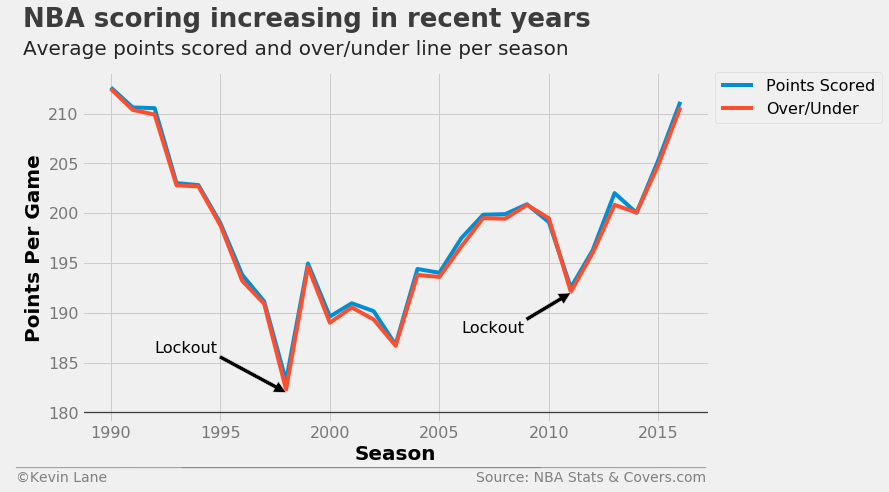

In [30]:
fig = plt.figure(figsize=(10, 6))
plt.plot(data.SEASON, data.AVG_PTS, label='Points Scored')
plt.plot(data.SEASON, data.AVG_OVER_UNDER, label='Over/Under')
plt.annotate('Lockout', xy=(1998, 182), xytext=(1992, 186), fontsize=16,
             arrowprops=dict(facecolor='black'))
plt.annotate('Lockout', xy=(2011, 192), xytext=(2006, 188), fontsize=16,
             arrowprops=dict(facecolor='black'))
plt.xlabel('Season')
plt.ylabel('Points Per Game')
plt.ylim(179)
plt.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)

title = 'NBA scoring increasing in recent years'
subtitle = 'Average points scored and over/under line per season'
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, xoff=(-0.12, 1.01),
           yoff=(-0.12, -0.17), toff=(-0.094, 1.13), soff=(-0.094, 1.05), bottomtick=180)
plt.show()

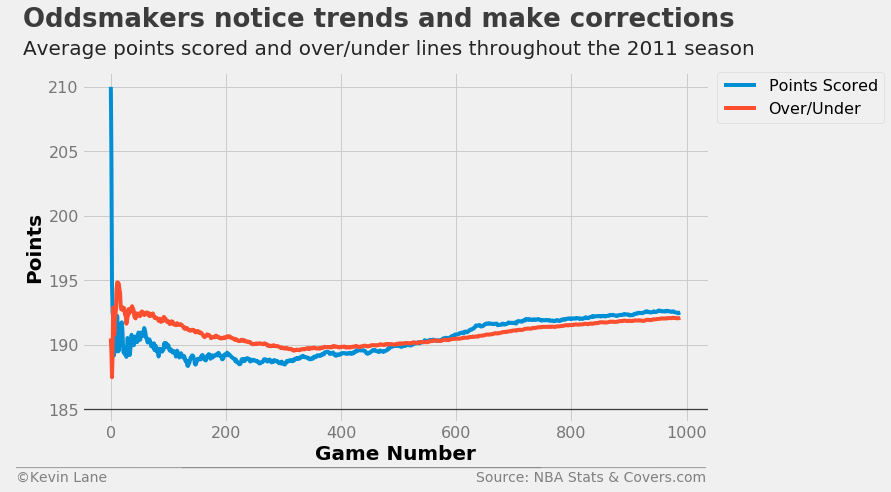

In [31]:
season = 2011
data = pd.read_sql('''
    SELECT
        2 * AVG(PTS) as TOTAL_PTS,
        OVER_UNDER
    FROM games
    JOIN team_game_stats ON games.ID IS team_game_stats.GAME_ID
    JOIN betting ON games.ID IS betting.GAME_ID
    WHERE SEASON == {:d}
    GROUP BY GAME_DATE, ID'''.format(season), conn)

x = range(0, len(data))
fig = plt.figure(figsize=(10, 6))
plt.plot(x, data.TOTAL_PTS.expanding().mean(), label='Points Scored')
plt.plot(x, data.OVER_UNDER.expanding().mean(), label='Over/Under')
plt.xlabel('Game Number')
plt.ylabel('Points')
plt.legend(fontsize=16, bbox_to_anchor=(1.28, 1), borderaxespad=0)
plt.ylim(184)

title = 'Oddsmakers notice trends and make corrections'
subtitle = 'Average points scored and over/under lines throughout the {:d} season'.format(season)
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, xoff=(-0.12, 1.01),
           yoff=(-0.12, -0.17), toff=(-0.094, 1.13), soff=(-0.094, 1.05), bottomtick=185)
plt.show()

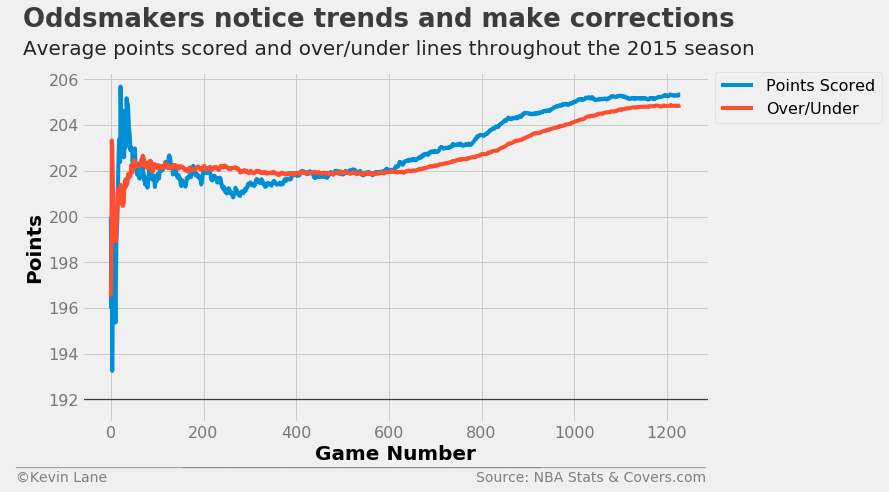

In [32]:
season = 2015
data = pd.read_sql('''
    SELECT
        2 * AVG(PTS) as TOTAL_PTS,
        OVER_UNDER
    FROM games
    JOIN team_game_stats ON games.ID IS team_game_stats.GAME_ID
    JOIN betting ON games.ID IS betting.GAME_ID
    WHERE SEASON == {:d}
    GROUP BY GAME_DATE, ID'''.format(season), conn)

x = range(0, len(data))
fig = plt.figure(figsize=(10, 6))
plt.plot(x, data.TOTAL_PTS.expanding().mean(), label='Points Scored')
plt.plot(x, data.OVER_UNDER.expanding().mean(), label='Over/Under')
plt.xlabel('Game Number')
plt.ylabel('Points')
plt.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.ylim(191)

title = 'Oddsmakers notice trends and make corrections'
subtitle = 'Average points scored and over/under lines throughout the {:d} season'.format(season)
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, xoff=(-0.12, 1.01),
           yoff=(-0.12, -0.17), toff=(-0.094, 1.13), soff=(-0.094, 1.05), bottomtick=192)

# plt.grid()
plt.show()

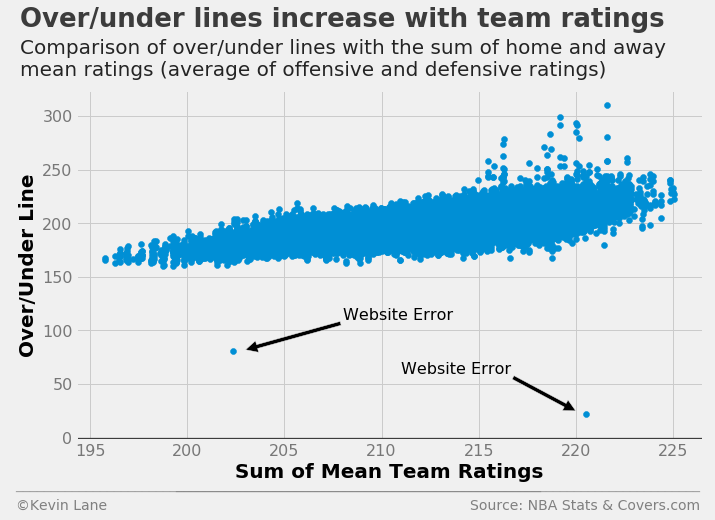

In [33]:
pts = (games.TEAM_OFF_RTG + games.TEAM_DEF_RTG + games.TEAM_OFF_RTG_AWAY + games.TEAM_DEF_RTG_AWAY) / 2
fig = plt.figure(figsize=(10, 6))
plt.scatter(pts, games['OVER_UNDER'])
plt.annotate('Website Error', xy=(203, 82), xytext=(208, 110), fontsize=16,
             arrowprops=dict(facecolor='black'))
plt.annotate('Website Error', xy=(220, 25), xytext=(211, 60), fontsize=16,
             arrowprops=dict(facecolor='black'))
plt.ylim(-2)

title = 'Over/under lines increase with team ratings'
subtitle = '''Comparison of over/under lines with the sum of home and away
mean ratings (average of offensive and defensive ratings)'''
format_538(fig, 'NBA Stats & Covers.com', xlabel='Sum of Mean Team Ratings', ylabel='Over/Under Line',
           title=title, subtitle=subtitle, xoff=(-0.11, 1.01), yoff=(-0.14, -0.2),
           toff=(-0.09, 1.18), soff=(-0.09, 1.04))
plt.show()